# Load, analyze and understand data from doa-zero-eeg-sample dataset

###### Author: Sofiane Sifaoui
###### This notebook aims to help team members and mentors to understand the dataset and how to interpret it. I will try to keep it updated during the project.

#### Recall from the Wiki of the Git project that the dataset is composed of 100 .parquet files. Each file corresponds to a scope sessions within operating rooms (most of the time, each scope session corresponds to a surgical operation, but there might be several scope sessions for the same surgical operation if the scope was turned off and on again for some reason, or there might be a scope session containing data for multiple patients if the same scope session was kept in between surgeries).

## Loading data

#### Our data are stored in a .parquet format, a file format well-suited for columnar storage

In [3]:
from pathlib import Path
import pandas as pd

path = Path("~/data/NoEEG/doa-zero-eeg-sample/0bdcf3ed-2177-4fca-99e7-79c2fa11de9e.parquet") # arbitrary choice for the purpose of this notebook
data = pd.read_parquet(path)

print(f"Shape of the data: {data.shape}")
print("Overview: \n")
data.head()


Shape of the data: (25744, 8)
Overview: 



SubLabel,BIS,CO₂fe,CO₂mi,FC,PNId,PNIm,PNIs,SpO₂
TimeStamp,,,,,,,,
2020-08-31 06:44:07.596000+00:00,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2020-08-31 06:44:08.620000+00:00,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2020-08-31 06:44:09.644000+00:00,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2020-08-31 06:44:10.668000+00:00,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2020-08-31 06:44:11.692000+00:00,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN


#### We have 8 columns, each storing a time serie acquired by a specific sensor (e.g, EEG sensor for the BIS index, ECG sensor for Cardiac Frequency (FC), etc.). Note that all the labels and their meaning are detailled in the Wiki of the Git repo. 

#### The DataFrame is indexing by timestamp (i.e, the time between two consecutive measurements). It seems to be sampled at 1 Hz (i.e, one measurement each second).

## Analyze the data

### Let's look at the duration of the scope session

In [4]:
ts_start = pd.to_datetime(data.index[0])
ts_end = pd.to_datetime(data.index[-1])

session_duration = ts_end - ts_start

hours = session_duration.components.hours
minutes = session_duration.components.minutes
seconds = session_duration.components.seconds

duration = f"{hours:02d}:{minutes:02d}:{seconds:02d}" # H:M:S format
print(f"Duration of the scope session: {duration}")

Duration of the scope session: 08:20:22


#### We will see later how we can determine if a scope session corresponds to a unique surgical operation or if it contains multiple patient's operation within the same recording

In [5]:
data.describe()

SubLabel,BIS,CO₂fe,CO₂mi,FC,PNId,PNIm,PNIs,SpO₂
count,9347.000000,17863.000000,17829.000000,24375.000000,78.000000,78.000000,78.000000,25022.000000
mean,45.217396,30.694620,2.126984,70.427116,74.679489,90.051285,126.051285,99.059036
std,24.208044,13.505414,1.501859,10.734295,16.677610,17.884113,25.410856,1.623927
min,16.000000,0.000000,0.000000,0.000000,25.000000,43.000000,72.000000,83.199997
25%,31.000000,34.000000,1.000000,66.000000,62.250000,74.750000,105.250000,98.800003
50%,35.000000,36.000000,2.000000,72.000000,78.500000,93.500000,128.500000,100.000000
75%,42.000000,38.000000,3.000000,76.000000,84.000000,101.750000,139.250000,100.000000
max,98.000000,47.000000,11.000000,135.000000,112.000000,122.000000,177.000000,100.000000


#### As we can see, we have a lot of heterogeneity in the data: some labels contain a lot of values (e.g, Sp02, FC) and others have very few values (especially PNI in that case). Note: I think this is because PNI values are acquired every 5 minutes (i.e, one measure each 5 minutes) using the tension cuff (but need to check with Valentin). 

#### For instance, for the Cardiac Frequency (FC), we know that common values for the cardiac frequency lies between 60-80 pulse/min. We can see that it is consistent here since the mean for label FC is equal to 70, with a standard deviation of 10.  

### Let's look at our DoA index: the BIS index. This is a numerical index developed by MedTronic to assess the DoA of a patient during a surgical operation. It is entirely based on the EEG signal (especially the power spectrum of the EEG signal). Note that the algorithm at the basis of this index doesn't include intelligence at all. 

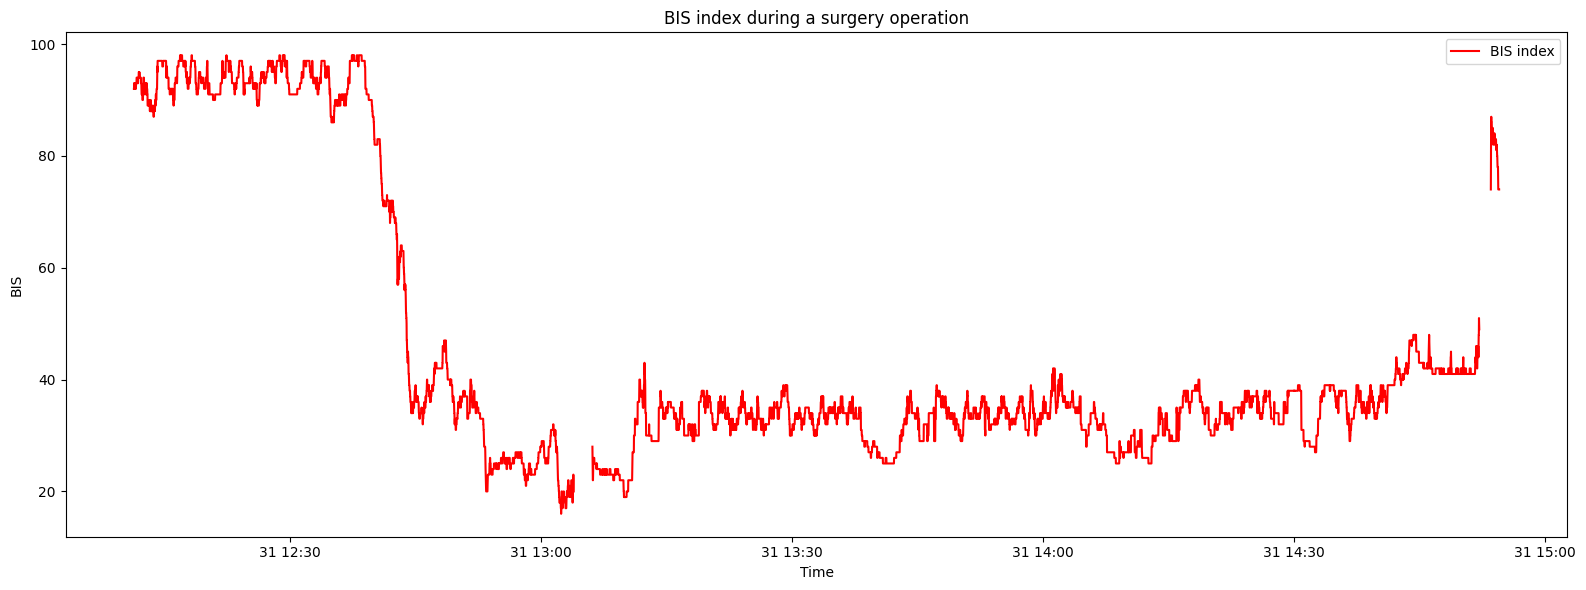

In [6]:
import matplotlib.pyplot as plt

bis = data["BIS"]

plt.figure(figsize=(16,6))
plt.plot(bis, label="BIS index", c="red")
plt.xlabel("Time")
plt.ylabel("BIS")
plt.title("BIS index during a surgery operation")
plt.legend()
plt.tight_layout()
plt.show()


#### This plot represents the BIS values distribution across the entire surgery (i.e for the time during which the EEG sensor were put on the patient forehand). We can see that the BIS index starts around 100, which is normal because the patient is still awake and being prepared for the surgery. Then, the anesthetic drugs are administered (around 12:40) in order to make the patient sleeping to perform the surgery (Induction). We can see that the BIS index drops suddenly from 90-100 to 20-40. Then, drugs are administered continuously to maintain the patient in a stable anesthetic state (Maintenance). At the end of the surgery (around 15:00), drugs administration is stopped and the patient starts to wake up (Awaking). These three steps: Induction, Maintenance and Awaking are the 3 main stages in General Anesthesia (GA).

#### Note that we have a lot of NaN values at the end of the surgery. This is because when drugs are stopped, there is no need to monitor the DoA because the patient will start to wake up. Therefore, doctors remove EEG sensor from the patient at the end of the surgery and the BIS index is not monitor anymore. 

### Now let's look at all the labels that we have

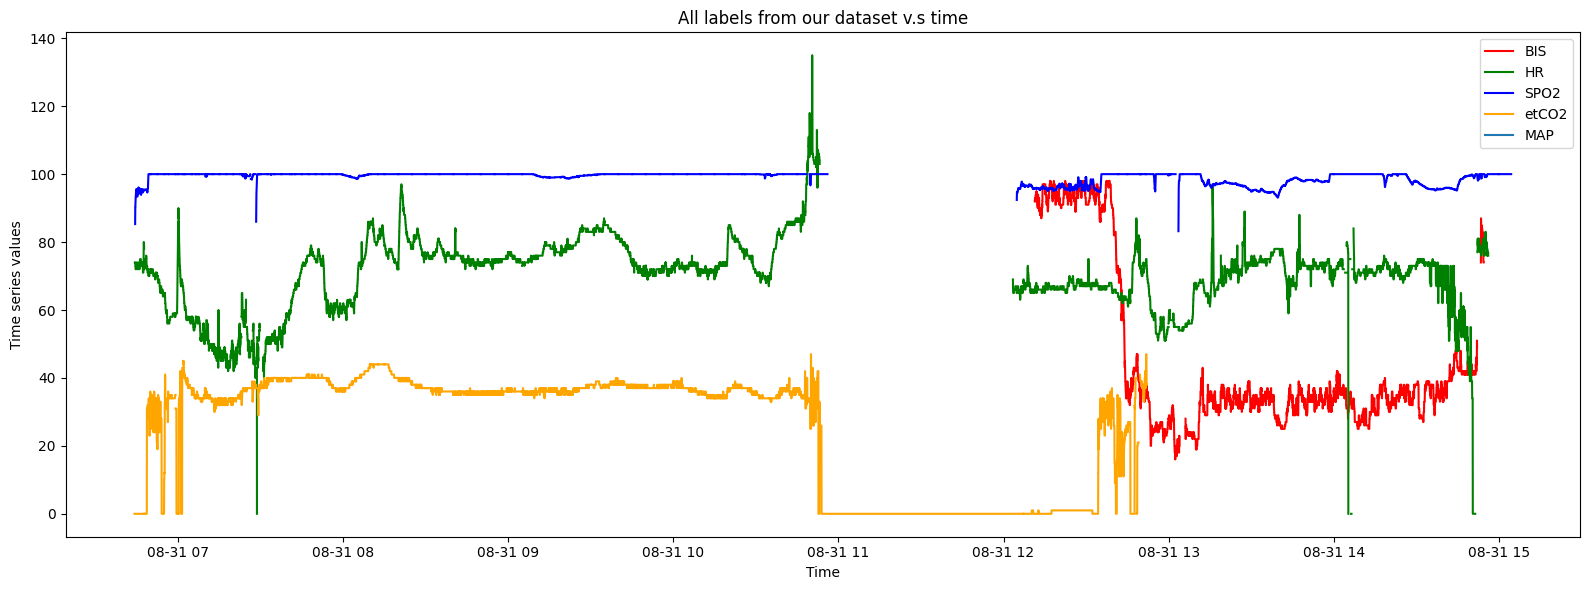

In [8]:
plt.figure(figsize=(16,6))

# Target (Ground Truth)
plt.plot(bis, label="BIS", c="r")

# Explanatory variables
plt.plot(data["FC"], label="HR", c="g")
plt.plot(data["SpO₂"], label="SPO2", c="b")
plt.plot(data["CO₂fe"], label="etCO2", c="orange")
plt.plot(data["PNIm"], label="MAP")

plt.xlabel("Time")
plt.ylabel("Time series values")
plt.title("All labels from our dataset v.s time")

plt.tight_layout()
plt.legend()
plt.show()

#### It seems that we have two distinct surgical operations within the same scope session here. The first surgery starts at 7am and ends at 11am, and the second one starts at 12:15pm and ends at 3pm. We can notice that the BIS was not monitored for the first surgery (maybe because the doctor doesn't want to use an EEG for this surgery? Perhaps the patient was not at risk?). However, for the second part of this scope session, we have effectively a BIS signal. 

#### Therefore, a part of our job will be to preprocess the data to determine which .parquet files corresponds to a single surgical operation, or if it contains multiple surgicial operation within the same scope session. 

#### For the moment, let's zoom into the second part of this recording:

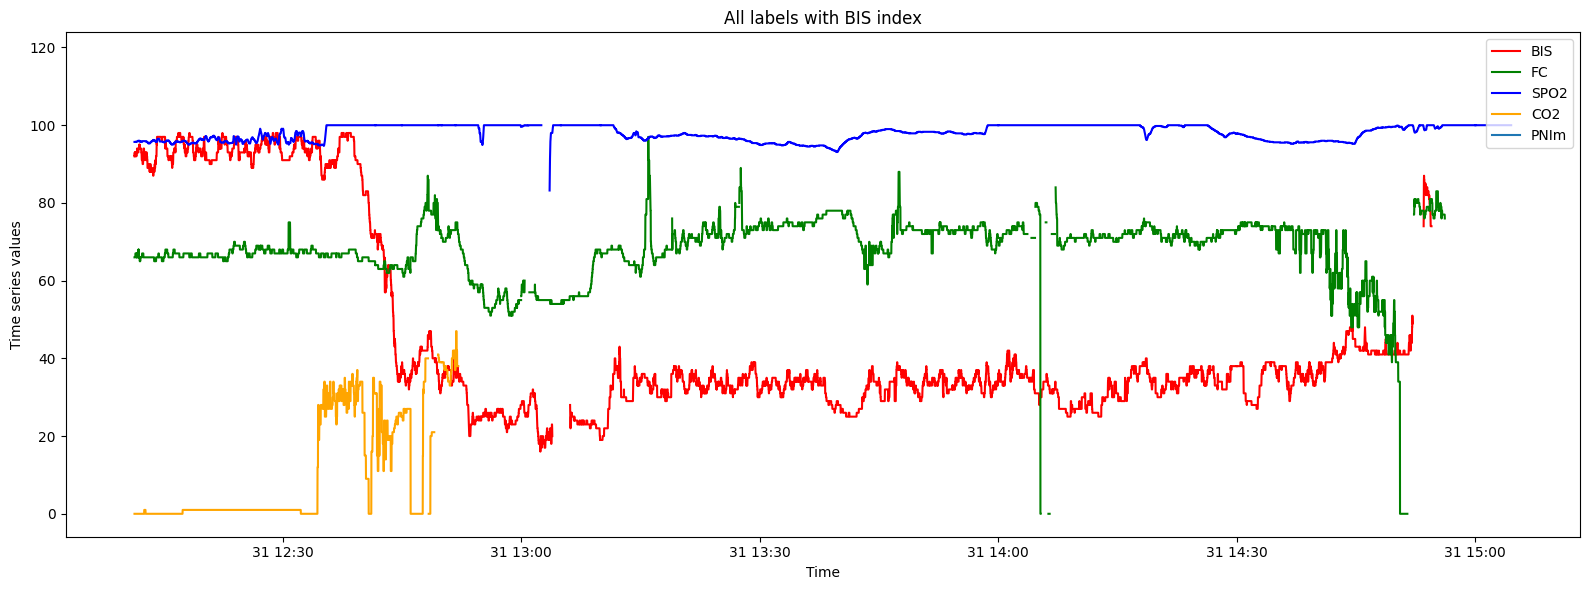

In [7]:
plt.figure(figsize=(16,6))

ts_start = data["BIS"].first_valid_index() # first timestamp for which we have a BIS signal (i.e not NaN)

plt.plot(data["BIS"].loc[ts_start:], label="BIS", c="r")

plt.plot(data["FC"].loc[ts_start:], label="FC", c="g")
plt.plot(data["SpO₂"].loc[ts_start:], label="SPO2", c="b")
plt.plot(data["CO₂fe"].loc[ts_start:], label="CO2", c="orange")
plt.plot(data["PNIm"].loc[ts_start:], label="PNIm")

plt.xlabel("Time")
plt.ylabel("Time series values")
plt.title("All labels with BIS index")

plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

#### Note that the PNIm (mean non invasive pressure) is not visible in these plots because of its sampling frequency. It think we have 1 measure of PNIm each 5 minutes (TBC).

## TODO

- Generate a plot like the last one for each recording (maybe apply some scaling?) to maybe try to identify pattern between a change in the BIS values and a change in the others clinical and/or physiological variables.
- Thinking about how to deal with missing data? How to deal with PNI which has an extremely low sampling frequency compared to other variables